In [1]:
import sys
from pathlib import Path
import importlib.util
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
import scipy.stats as stats
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from pandas.plotting import table

# notebooks/.. = project_root
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


package_dir = project_root / "scdb_code_map"
init_file = package_dir / "__init__.py"
init_file.touch(exist_ok=True)  # creates empty __init__.py if missing


spec = importlib.util.find_spec("scdb_code_map")
if spec is None:
    raise ImportError(f"Cannot find 'scdb_code_map' in {project_root}")


from scdb_code_map import LAW_SUPP_MAP, LAW_TYPE_MAP, DECISION_DIRECTION_MAP, AUTHORITY_DECISION_MAP

In [2]:
conn = sqlite3.connect("../data/legal_sc.db")
c_issues = pd.read_sql("SELECT * FROM c_issues", conn)

In [7]:
# Analyzes the most frequently cited laws or amendments.

def analyze_citations(df, max_len=40):

    # Map lawSupp and lawType to words
    df["lawSuppText"] = df["lawSupp"].map(LAW_SUPP_MAP).fillna("Unknown")
    df["lawTypeText"] = df["lawType"].map(LAW_TYPE_MAP).fillna("Unknown")

    # Drop rows where either lawSuppText or lawTypeText columns ended up as "Unknown"
    # use the | symbol for "OR" logic
    df_clean = df[
        (df["lawSuppText"] != "Unknown") & 
        (df["lawTypeText"] != "Unknown")
    ]

    # keeps the LawSupp and lawType and its Category together
    # count the number of occurrences for each unique pair
    law_counts = df_clean.groupby(['lawSuppText', 'lawTypeText']).size().sort_values(ascending=False)

    # print the result
    print("--- Top 10 Most Cited Laws (with Category) ---")
    print(law_counts.head(10))

    # Convert to DataFrame and name the count column
    top_cited = law_counts.head(10).to_frame(name='# Cited')

    # Move lawSuppText and lawTypeText from the index into actual columns
    top_cited = top_cited.reset_index()


    # Truncate long law names
    top_cited['lawSuppText'] = top_cited['lawSuppText'].apply(
        lambda x: x if len(x) <= max_len else x[:max_len] + "…"
    )
    
    # Rename the columns
    top_cited = top_cited.rename(columns={
        'lawSuppText': 'Law Cited',
        'lawTypeText': 'Law Type'
    })

    # try to add a title and style the table
    styled_table = (
        top_cited.style
        .hide(axis='index')
        .set_caption("Most Cited Laws in Supreme Court Cases")
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('color', 'black'),
                ('font-size', '16px'),
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('padding-bottom', '10px')
            ]}
        ])
        .set_properties(**{
            'text-align': 'left',
            'padding': '10px'
        })
    )

    # save the table as a jpeg
    dfi.export(
        styled_table, 
        '../results/tbl_mostCitedLaw.jpg', 
        table_conversion='matplotlib'
    )

    return law_counts


results = analyze_citations(c_issues)


--- Top 10 Most Cited Laws (with Category) ---
lawSuppText                                                                                                                               lawTypeText                    
Infrequently litigated statutes                                                                                                           Infrequently litigated statutes    2550
Fourteenth Amendment (due process)                                                                                                        Constitutional Amendment            608
First Amendment (speech, press, and assembly)                                                                                             Constitutional Amendment            529
Fourteenth Amendment (equal protection)                                                                                                   Constitutional Amendment            489
Internal Revenue Code and pre-IRC revenue acts                         

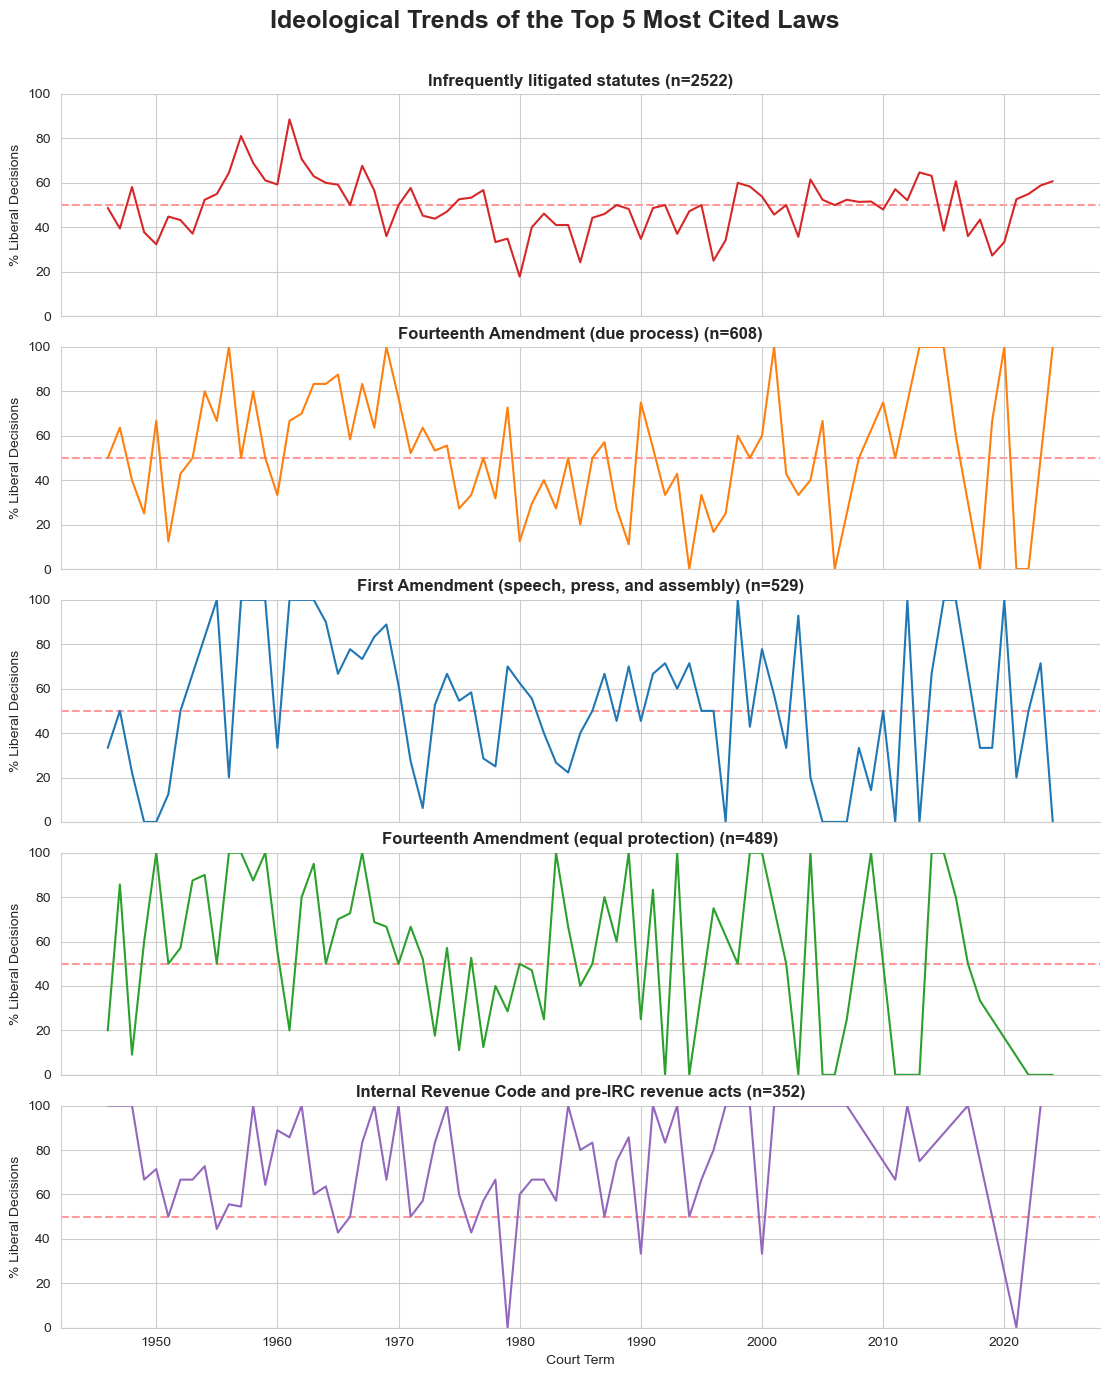

In [4]:
# For the most cited laws, check whether the decision become more liberal or conservative over time

def plot_ideological_trends_vertical(df):
    # Map lawSupp to readable names and clean data
    df["lawSuppText"] = df["lawSupp"].map(LAW_SUPP_MAP).fillna("Unknown")
    
    # Filter for valid decision directions and drop Unknowns laws
    df_clean = df[
        (df["lawSuppText"] != "Unknown") & 
        (df["decisionDirection"].isin([1, 2]))
    ].copy()
    
    # Identify top n laws and sort from high to low
    n = 5
    counts = df_clean['lawSuppText'].value_counts().head(n)
    top_laws_ordered = counts.index.tolist() # a list of n most frequent lawSuppText values, ordered high to low
    
    # uses list comprehension and string formatting to create readable labels that include both the law name and its count
    # create labels that look like Section 123 (n=42)
    order_with_counts = [f"{law} (n={counts[law]})" for law in top_laws_ordered] # this is a list used for plotting later
    
    # Add the display label to the dataframe
    name_map = {law: f"{law} (n={counts[law]})" for law in top_laws_ordered} # this is a dictionary
    df_top = df_clean[df_clean['lawSuppText'].isin(top_laws_ordered)].copy()
    df_top['law_label'] = df_top['lawSuppText'].map(name_map)
    
    # Calculate Liberalism Score per Term per Law, 1 = conservative, 2 = liberal
    # assign 1 if True ('decisionDirection'] == 2), 0 if False
    df_top['is_liberal'] = (df_top['decisionDirection'] == 2).astype(int)
    trend_data = (
        df_top.groupby(['term', 'law_label'])['is_liberal'] # for a given year and law cited, give faction of liberal decision
        .mean()
        .reset_index()
    )
    trend_data['is_liberal'] *= 100 
    
    # Visualization using vertical panels where the year/term on x-axis is aligned for each law
    sns.set_style("whitegrid")
    
    g = sns.relplot(
        data=trend_data,
        x='term',
        y='is_liberal',
        row='law_label',
        row_order=order_with_counts, 
        hue='law_label',
        kind='line',
        height=2.8,         # Slightly taller rows
        aspect=4.0,         # Wide enough for the timeline
        facet_kws={'sharey': True, 'sharex': True},
        legend=False
    )

    # Adding the netrality line (50%) to every panel
    g.map(plt.axhline, y=50, color='red', linestyle='--', alpha=0.4, zorder=0)

    # formatting titles and labels
    g.set_titles(row_template="{row_name}", size=12, weight='bold')
    g.set_axis_labels("Court Term", "% Liberal Decisions")
    g.set(ylim=(0, 100)) 

    # Fix title to make sure there is enough room for title to not overlap on top of each other
    
    plt.subplots_adjust(top=0.92) 
    g.figure.suptitle(
        'Ideological Trends of the Top 5 Most Cited Laws', 
        fontsize=18, 
        fontweight='bold',
        y=0.98  
    )
    # -----------------------------

    # save
    # bbox_inches='tight' is crucial for tall figures
    plt.savefig('../results/MostCitedLaw_decision_trends.jpg', bbox_inches='tight', dpi=300)
    plt.show()

plot_ideological_trends_vertical(c_issues)

In [3]:
# Look at whether the Court lean more conservative or liberal based on authorityDecision1
# authorityDecision1 tells whether the authority is based on judicial review of state/local laws versus federal statutes etc

# Map authority codes to text
c_issues["authorityDecision1Text"] = c_issues["authorityDecision1"].map(AUTHORITY_DECISION_MAP)

# Map decision direction
c_issues["decisionDirectionText"] = c_issues["decisionDirection"].map(
    DECISION_DIRECTION_MAP
)

# Drop unclear outcomes (not conservative or liberal)
c_issues_clean = c_issues[c_issues["decisionDirectionText"] != "Unclear"].copy()

# reset to boolean coding Conservative = 1, Liberal = 0
c_issues_clean["conservative"] = (c_issues_clean["decisionDirectionText"] == "Conservative").astype(int)

# n_cases counts the number of rows in each group, essentially number of cases for that authority type
# Since conservative is coded 1 for Conservative, 0 for Liberal, the mean = proportion of Conservative cases in that group
summary = (
    c_issues_clean.groupby("authorityDecision1Text")
      .agg(
          n_cases=("conservative", "size"),
          pct_conservative=("conservative", "mean")
      )
)

print(summary)

# Interpretation
# since all results are near 0.5, the type of authority (authorityDecision1) does not strongly predict 
# whether the Court rules Conservative or Liberal

                                                    n_cases  pct_conservative
authorityDecision1Text                                                       
Diversity jurisdiction                                   22          0.500000
Federal common law                                      894          0.493289
Interpretation of administrative regulation or ...      684          0.502924
Judicial review (national level)                       1855          0.549326
Judicial review (state level)                          2950          0.467458
Statutory construction                                 5762          0.481777
Supreme Court supervision of lower federal or s...     1460          0.506849


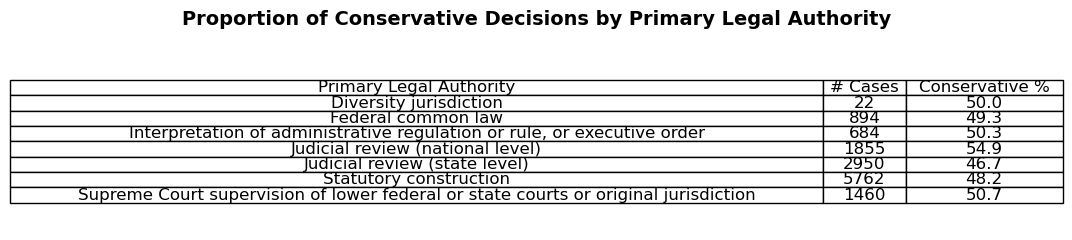

In [11]:
# plot ans save the table above as jpg
# not using dfi.export, build the table manually with matplotlib 

# Reset index and rename column
summary_reset = summary.reset_index()
summary_reset = summary_reset.rename(columns={
    "authorityDecision1Text": "Primary Legal Authority",
    "n_cases": "# Cases",
    "pct_conservative": "Conservative %"
})

# format pct_conservative as percentage with 1 decimal
summary_reset["Conservative %"] = (summary_reset["Conservative %"] * 100).round(1)

# Create figure
fig, ax = plt.subplots(figsize=(12, 2.5))  # adjust size as needed
ax.axis('off')

# Add a title
plt.title("Proportion of Conservative Decisions by Primary Legal Authority", fontsize=14, fontweight='bold', pad=20)

# Create table
tbl = ax.table(
    cellText=summary_reset.values,
    colLabels=summary_reset.columns,
    cellLoc='center',
    loc='center'
)

# Adjust font size and column width
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.auto_set_column_width(col=list(range(len(summary_reset.columns))))

# Save as JPEG
plt.tight_layout()
plt.savefig("../results/tbl_authority_decisions_trend.jpeg", dpi=300, bbox_inches='tight')
plt.show() 
plt.close()